# Chapter 4 - SARIMAX

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [3]:
url1 = ('https://raw.githubusercontent.com/Apress/hands-on-time-series-analylsis-python/refs/heads/master/Data/FB.csv')
df = pd.read_csv(url1)

df['date'] = pd.to_datetime(df['Date'])    # Ensure it's in datetime format
df = df.set_index('date')                  # Set as index
df = df.sort_index()                       # Sort the index chronologically
df.drop(columns='Date', inplace=True)      # Drop 'Date' column if still present
df.head()

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600


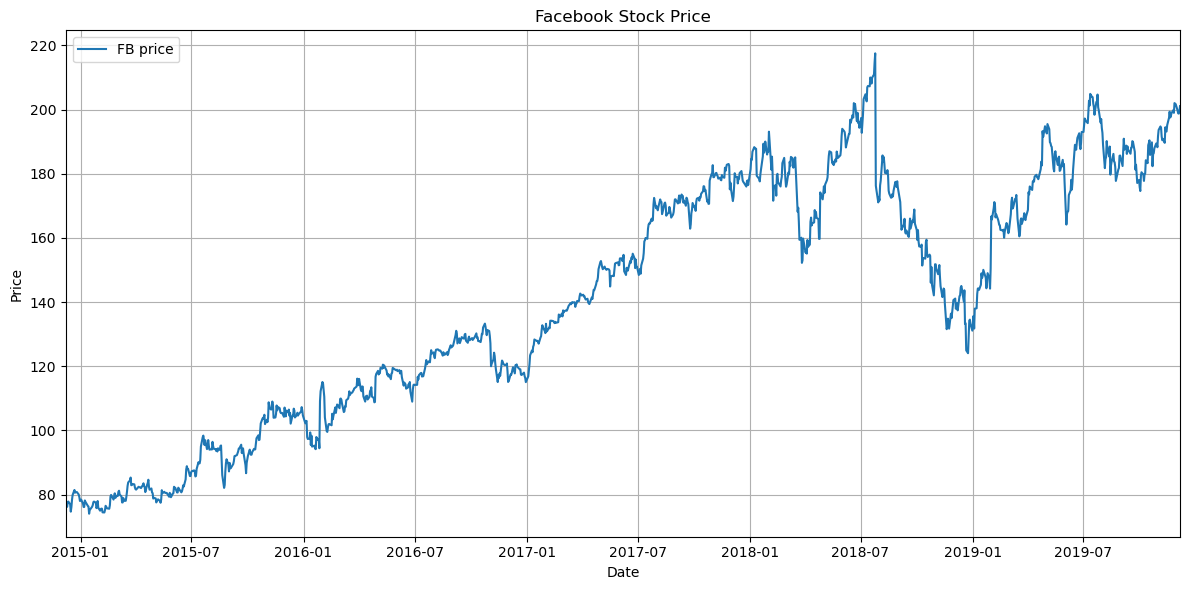

In [4]:
# Plot serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df.index, df['Close'], label='FB price')     

plt.title('Facebook Stock Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2014-12-08'), pd.to_datetime('2019-12-06'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [5]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    print('Evaluation metric results:')
    print(f' MSE is : {metrics.mean_squared_error(y_true, y_pred):.4f}')
    print(f' MSE is : {metrics.mean_absolute_error(y_true, y_pred):.4f}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred)):.4f}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred):.4f}')
    print(f'  R2 is : {metrics.r2_score(y_true, y_pred):.4f}',end='\n\n')

In [6]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
        
    print (dfoutput)
    
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [7]:
for name, column in df[['Close', 'Open', 'High', 'Low']].items():        # For each column:
    Augmented_Dickey_Fuller_Test_func(df[name], name)                    # Call your ADF test function
    print('\n')                                                          # Add spacing between outputs

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -1.338096
p-value                           0.611568
No Lags Used                      0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Open
Test Statistic                   -1.014123
p-value                           0.748078
No Lags Used                     11.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                   -1.255326
p-value                      

In [8]:
def determine_nonseasonal_d(series, name, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return print(f"\n {name}: Non-seasonal differencing term (d): {d}")
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return print(f"{name}: Non-seasonal differencing term (d): {d}")  


for name, column in df[['Close', 'Open', 'High', 'Low']].items():        # For each column:
    determine_nonseasonal_d(df[name], name)                    # Call your ADF test function
    print('\n')                                                          # Add spacing between outputs

d = 0 | ADF Statistic = -1.3381, p-value = 0.6116
d = 1 | ADF Statistic = -36.1146, p-value = 0.0000
Close: Non-seasonal differencing term (d): 1


d = 0 | ADF Statistic = -1.0141, p-value = 0.7481
d = 1 | ADF Statistic = -12.0912, p-value = 0.0000
Open: Non-seasonal differencing term (d): 1


d = 0 | ADF Statistic = -1.2553, p-value = 0.6494
d = 1 | ADF Statistic = -34.8736, p-value = 0.0000
High: Non-seasonal differencing term (d): 1


d = 0 | ADF Statistic = -1.0068, p-value = 0.7508
d = 1 | ADF Statistic = -13.4874, p-value = 0.0000
Low: Non-seasonal differencing term (d): 1




In [9]:
from pmdarima.arima import nsdiffs

def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
        
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

for m in  [4, 7, 12, 24, 30, 52]:

    D = determine_seasonal_D(df['Close'], m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 4: 0
Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 12: 0
Seasonal differencing term (D) for 24: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


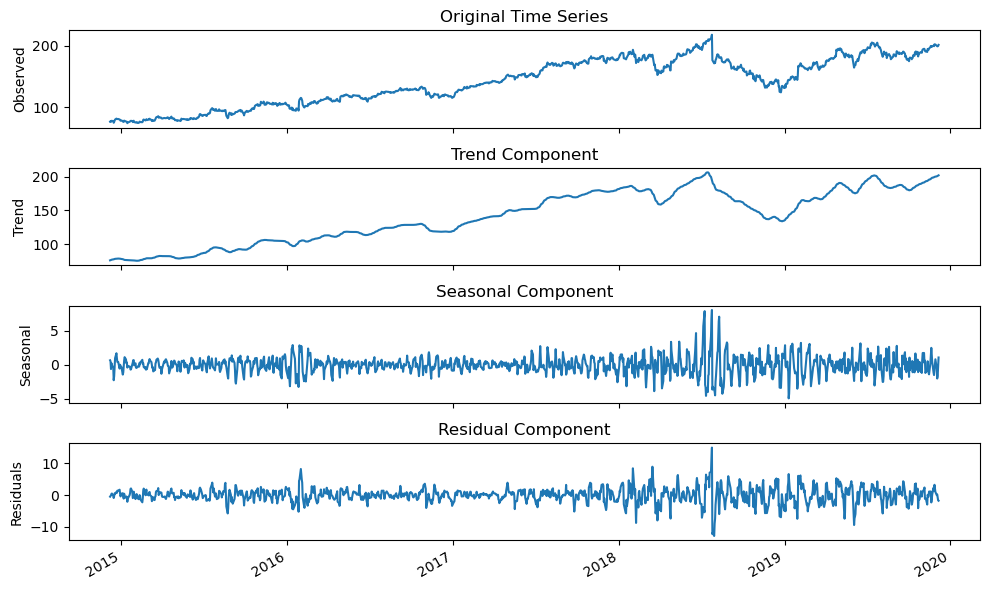

In [10]:
from statsmodels.tsa.seasonal import STL

decom_close = STL(df['Close'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,6))

ax1.plot(decom_close.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_close.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_close.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_close.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [11]:
X = df[['Close' ]]         # Select 'Close' column as the target variable for forecasting

actualtrain = X[0:-30]     # Use all rows except last 30 as training data
actualtest = X[-30:]       # Use last 30 rows as test data

exoX = df[['Open' ]]       # Select 'Open' column to use as an exogenous variable

exotrain = exoX[0:-30]     # Exogenous training data: all rows except last 30
exotest = exoX[-30:]       # Exogenous test data: last 30 rows

In [12]:
stepwise_model = auto_arima(actualtrain,
                            exogenous = exotrain,
                            start_p=1, start_q=1,
                            max_p=7, max_q=7, 
                            seasonal=True,
                            start_P=1,start_Q=1,
                            max_P=7,max_D=7,max_Q=7,
                            m=30,
                            d=None,D=None, 
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=6.24 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=5929.302, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=5928.920, Time=0.93 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=5929.018, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=5928.648, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=5927.161, Time=0.76 sec
 ARIMA(0,1,0)(2,0,0)[30] intercept   : AIC=5928.900, Time=6.97 sec
 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=5927.271, Time=0.85 sec
 ARIMA(0,1,0)(2,0,1)[30] intercept   : AIC=inf, Time=26.04 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=5928.912, Time=1.08 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=5924.904, Time=3.24 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=5926.792, Time=0.42 sec
 ARIMA(1,1,1)(2,0,0)[30] intercept   : AIC=5926.699, Time=34.07 sec
 ARIMA(1,1,1)(0,0,1)[30] interce

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA (p,d,q)(P,D,Q,S) model
sarimax_model = SARIMAX(actualtrain,                     # Endogenour Variable
                    exogenous = exotrain,                # Exogenous variable
                    order=(1, 1, 1),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 0, 30),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
sarimax_model_fit = sarimax_model.fit()

# Display summary of the model
print(sarimax_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 1229
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 30)   Log Likelihood               -2897.156
Date:                             Fri, 11 Apr 2025   AIC                           5802.312
Time:                                     15:19:53   BIC                           5822.662
Sample:                                          0   HQIC                          5809.979
                                            - 1229                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8418      0.120      7.033      0.000       0.607       1.076
ma.L1         -0.8766      

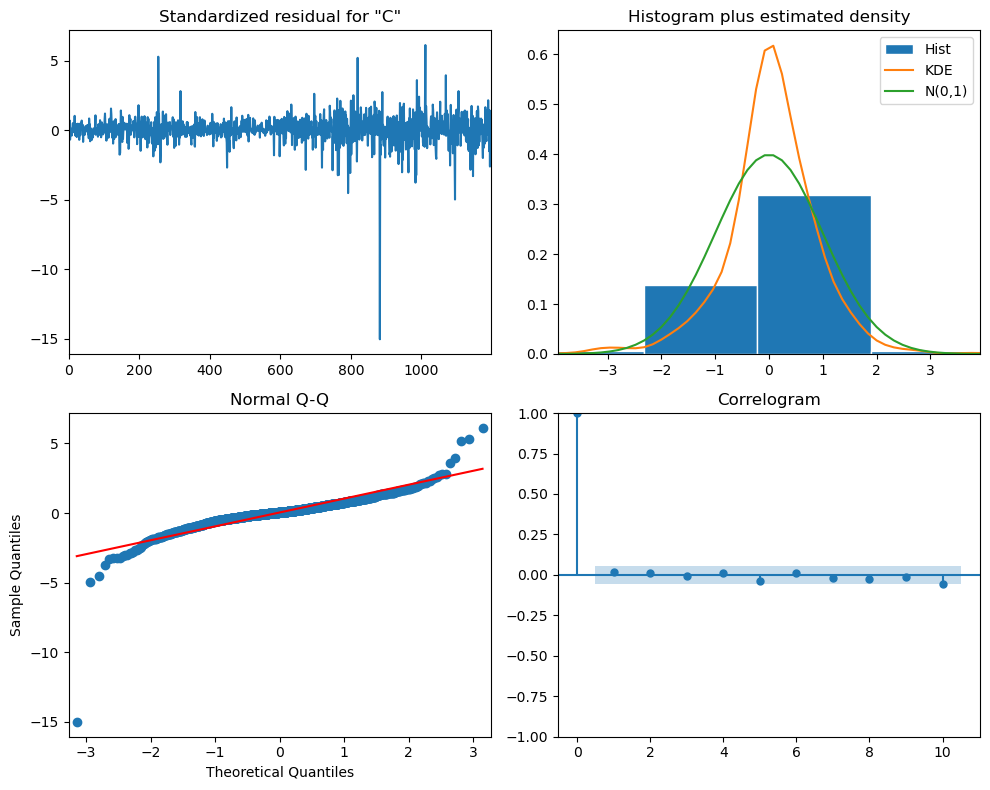

In [14]:
# Diagnostic plots for the model, including residuals and other model checks
sarimax_model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox


# Extract the residuals (errors) from the fitted model
residuals = sarimax_model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,26.081569,3.272933e-07
2,26.105995,2.143656e-06
3,26.203947,8.644171e-06
4,26.213048,2.866348e-05
5,27.001342,5.700815e-05
6,27.124104,1.372569e-04
7,27.155403,3.124816e-04
8,27.255837,6.385381e-04
9,27.390560,1.205071e-03
10,28.139669,1.714581e-03


In [16]:
from statsmodels.stats.stattools import durbin_watson

# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.9179
Conclusion: No significant autocorrelation.


In [17]:
# Forecast the next 12 time points
forecast_30 = sarimax_model_fit.get_forecast(steps=30)

# Extract predicted mean and confidence intervals
forecast_mean_30 = forecast_30.predicted_mean
conf_int_30 = forecast_30.conf_int()

# Assign forecasts to the test DataFrame
actualtest['Forecast'] = forecast_mean_30.values                                # Forecast mean

actualtest['Error'] = actualtest['Forecast'] - actualtest['Close']

actualtest['Lower 95% CI'] = conf_int_30.iloc[:, 0].values                      # Lower bound
actualtest['Upper 95% CI'] = conf_int_30.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
actualtest.head()

,Close,Forecast,Error,Lower 95% CI,Upper 95% CI
date,,,,,
2019-10-25,187.889999,186.310560,-1.579439,180.978555,191.642566
2019-10-28,189.399994,186.209212,-3.190782,178.798840,193.619584
2019-10-29,189.309998,186.280233,-3.029765,177.346504,195.213963
2019-10-30,188.250000,186.252069,-1.997931,176.082861,196.421277
2019-10-31,191.649994,186.342230,-5.307764,175.119512,197.564948


In [18]:
timeseries_evaluation_metrics_func(actualtest['Close'], actualtest['Forecast'])

Evaluation metric results:
 MSE is : 106.9496
 MSE is : 9.4018
RMSE is : 10.3416
MAPE is : 4.7683
  R2 is : -4.8434



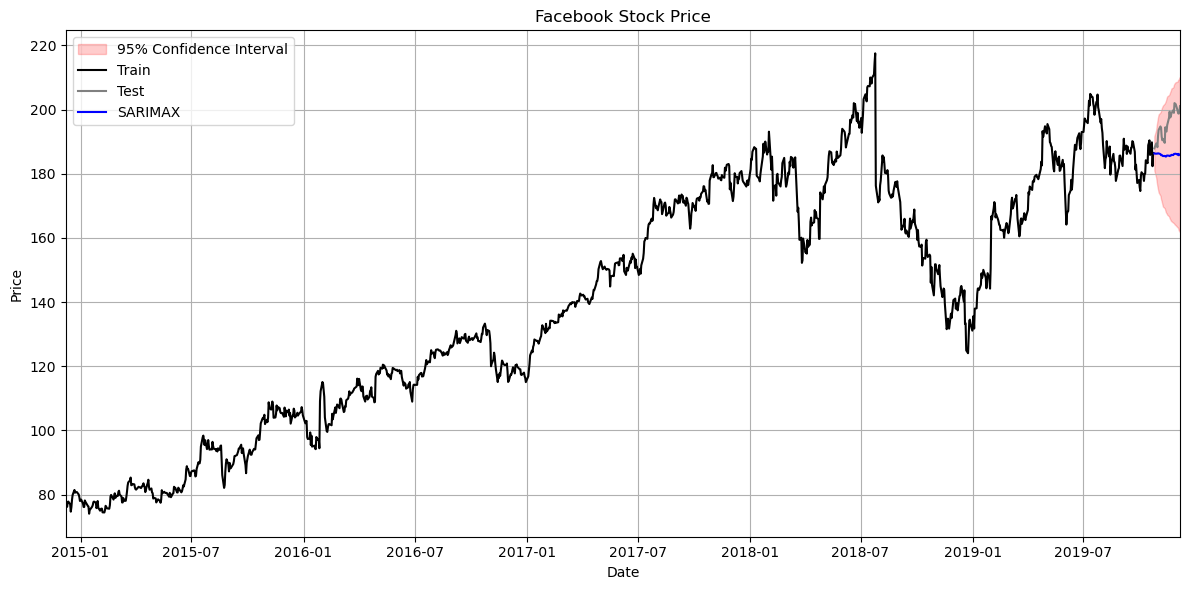

In [19]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(actualtest.index,
                 conf_int_30.iloc[:, 0],     # Lower bound
                 conf_int_30.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(actualtrain.index, actualtrain['Close'], label='Train', color='black')                      
plt.plot(actualtest.index, actualtest['Close'], label='Test', color='gray')     
plt.plot(actualtest.index, actualtest['Forecast'], label='SARIMAX', color='blue') 
#plt.plot(test.index, test2['ForecastS'], label='SARIMA', color='purple') 

plt.title('Facebook Stock Price')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2014-12-08'), pd.to_datetime('2019-12-06'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [20]:
# Calculate MAPE for each forecast
mape_sarimax = (np.abs(actualtest['Error']) / actualtest['Close']).mean() * 100

# Display MAPE results
print(f'MAPE for SARIMA model: {mape_sarimax:.2f}')

MAPE for SARIMA model: 4.77


The same MAPE value was found using the same model parameters, but without exogenous variables.

# VAR

In [21]:
from statsmodels.tsa.api import VAR
from sklearn import metrics
from timeit import default_timer as timer

In [22]:
url1 = ('https://raw.githubusercontent.com/Apress/hands-on-time-series-analylsis-python/refs/heads/master/Data/Dow_Jones_Industrial_Average.csv')
df2 = pd.read_csv(url1, parse_dates=True)

df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-14,16159.009766,16482.050781,16075.120117,16379.049805,16379.049805,158830000
1,2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2,2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
3,2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
4,2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000


In [23]:
df2['Date'] = pd.to_datetime(df2['Date'])     # Ensure 'Date' is datetime

df2 = df2[(df2['Date'] > '2016-01-14') & (df2['Date'] <= '2017-01-30')] # Filter

df2.set_index('Date', inplace=True)           # Make 'Date' be the index

df2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078,15988.080078,239210000
2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531,16016.019531,144360000
2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234,15766.740234,191870000
2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688,15882.679688,145140000
2016-01-22,15921.099609,16136.790039,15921.099609,16093.509766,16093.509766,145850000


In [24]:
df2.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-24,19794.679688,19949.240234,19786.710938,19912.710938,19912.710938,374460000
2017-01-25,19994.480469,20082.000000,19994.480469,20068.509766,20068.509766,372240000
2017-01-26,20076.250000,20125.580078,20067.529297,20100.910156,20100.910156,356730000
2017-01-27,20103.359375,20115.970703,20072.640625,20093.779297,20093.779297,343130000
2017-01-30,20028.619141,20028.619141,19870.390625,19971.130859,19971.130859,317280000


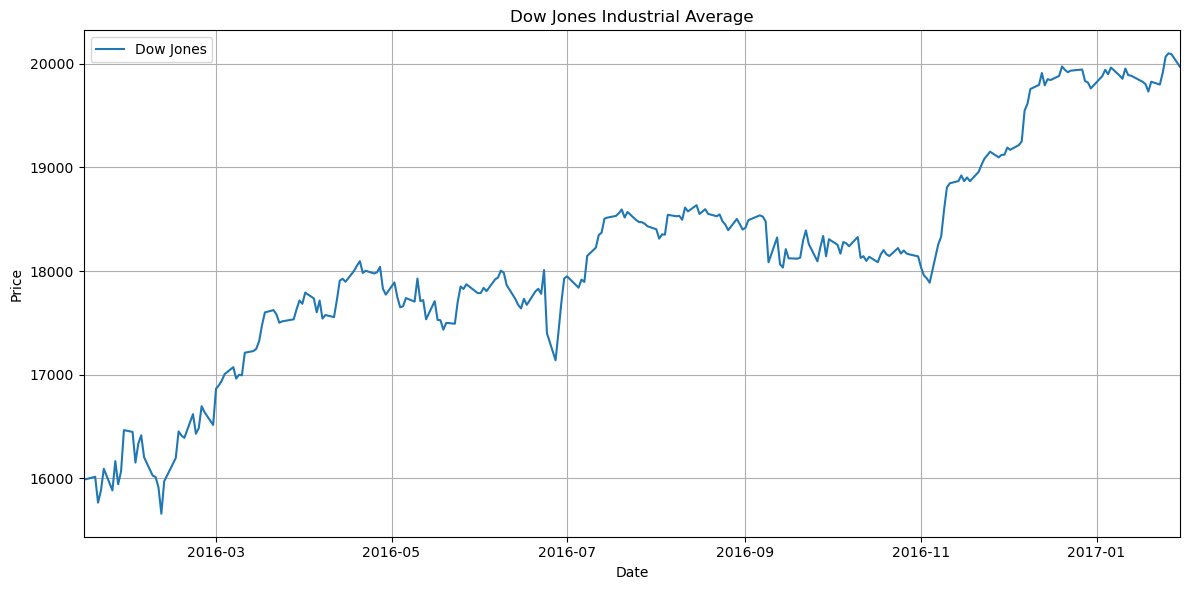

In [25]:
# Plot serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df2.index, df2['Close'], label='Dow Jones')     

plt.title('Dow Jones Industrial Average')                      
plt.xlabel('Date')                                        
plt.ylabel('Price')  
plt.xlim(pd.to_datetime('2016-01-15'), pd.to_datetime('2017-01-30'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

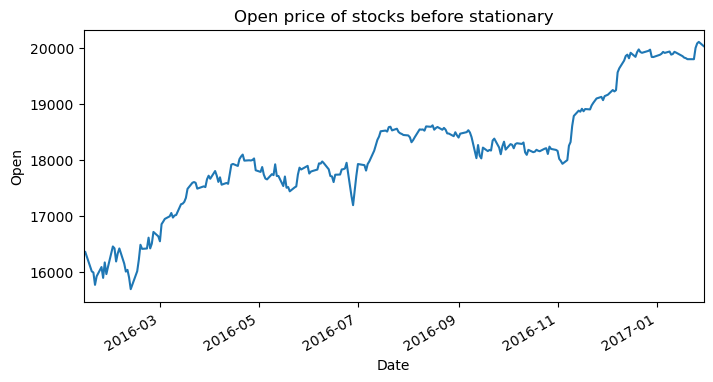

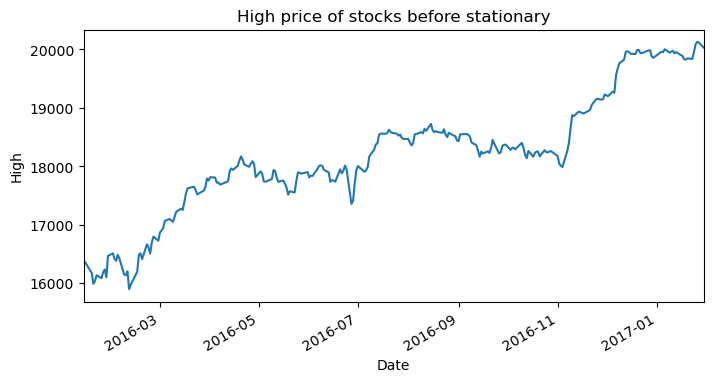

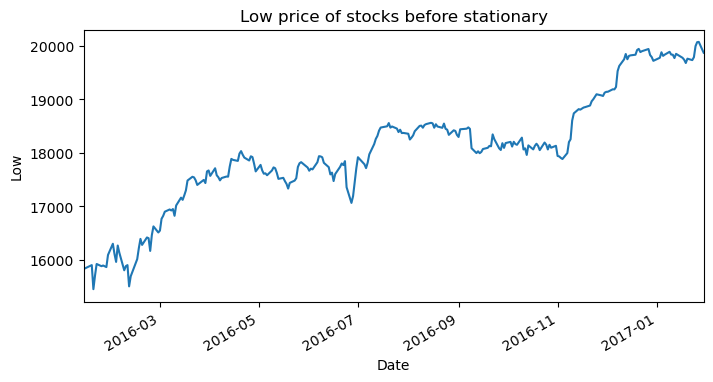

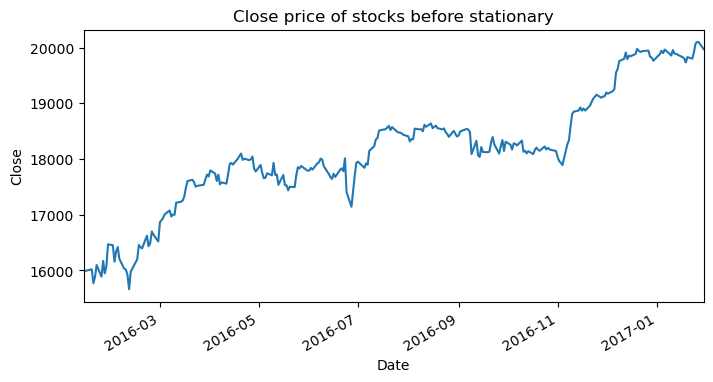

In [26]:
for c in df2[['Open', 'High', 'Low', 'Close']]:
    df2[str(c)].plot(figsize=(8, 4))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} price of stocks before stationary")
    plt.xlim(pd.to_datetime('2016-01-14'), pd.to_datetime('2017-01-30'))
    plt.show()

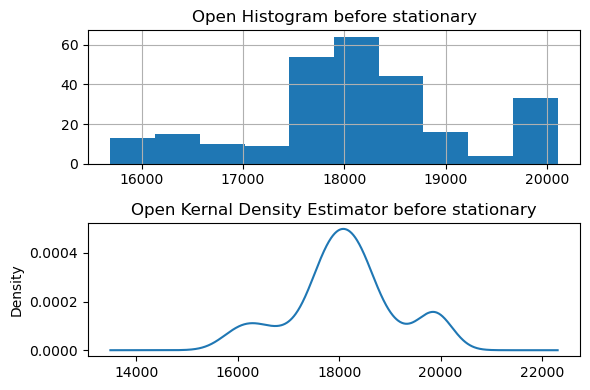

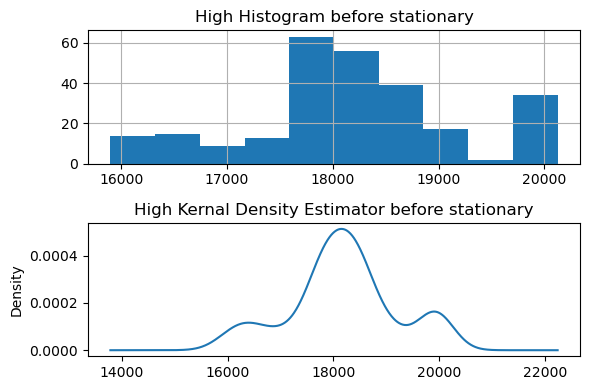

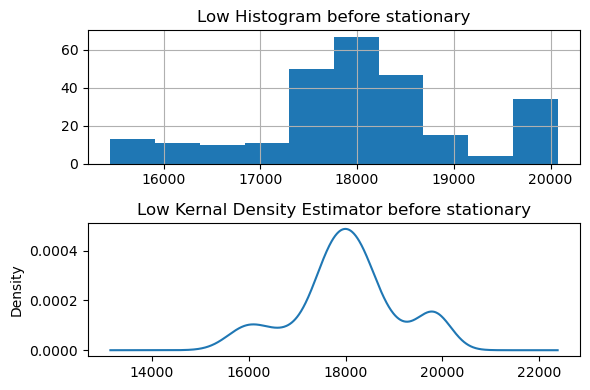

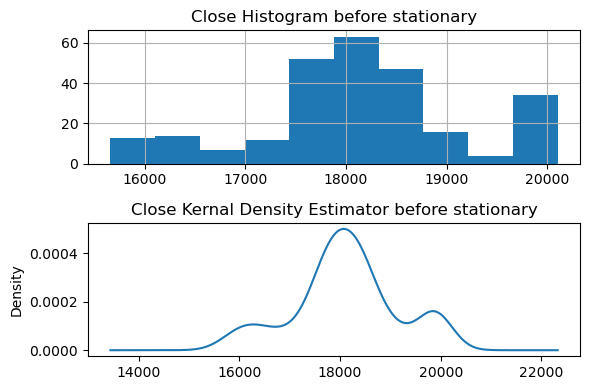

In [27]:
for c in df2[['Open', 'High', 'Low', 'Close']]:
    plt.figure(1, figsize=(6,4))
    plt.subplot(211)
    plt.title(f"{str(c)} Histogram before stationary")
    df2[str(c)].hist()
    plt.subplot(212)
    df2[str(c)].plot(kind='kde')
    plt.title(f"{str(c)} Kernal Density Estimator before stationary")
    plt.tight_layout() 
    plt.show()

In [28]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
    #print('Evaluation metric results:-')
    print(f' MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f' MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'  R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    
    return 

In [29]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [30]:
for name, column in df[['Open', 'High', 'Low', 'Close']].items():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                   -1.014123
p-value                           0.748078
No Lags Used                     11.000000
Number of Observations Used    1247.000000
Critical Value (1%)              -3.435605
Critical Value (5%)              -2.863861
Critical Value (10%)             -2.568005
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                   -1.255326
p-value                           0.649355
No Lags Used                      0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                   -1.006754
p-value                        

In [31]:
X = df2[['Open', 'High', 'Low', 'Close' ]]
train, test = X[0:-30], X[-30:]

In [32]:
train_diff = train.diff()
train_diff.dropna(inplace = True)

In [33]:
for name, column in train_diff[['Open', 'High', 'Low', 'Close' ]].items():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                -1.579687e+01
p-value                        1.085613e-28
No Lags Used                   0.000000e+00
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                -1.172782e+01
p-value                        1.364178e-21
No Lags Used                   1.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                  -3.997846
p-value                          0.001422


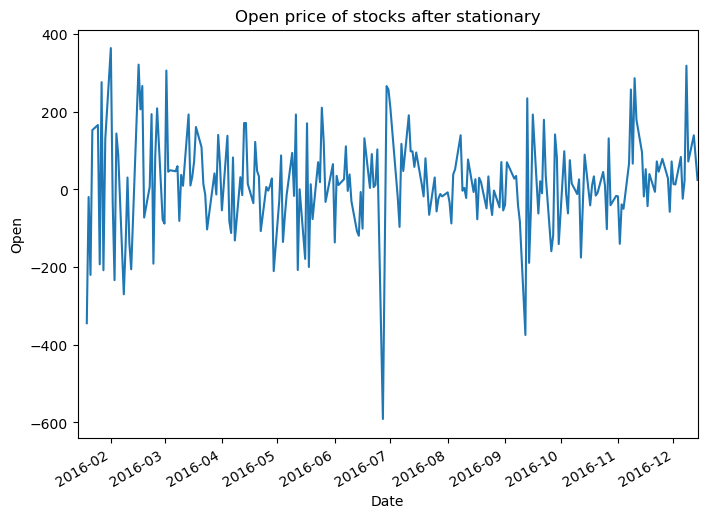

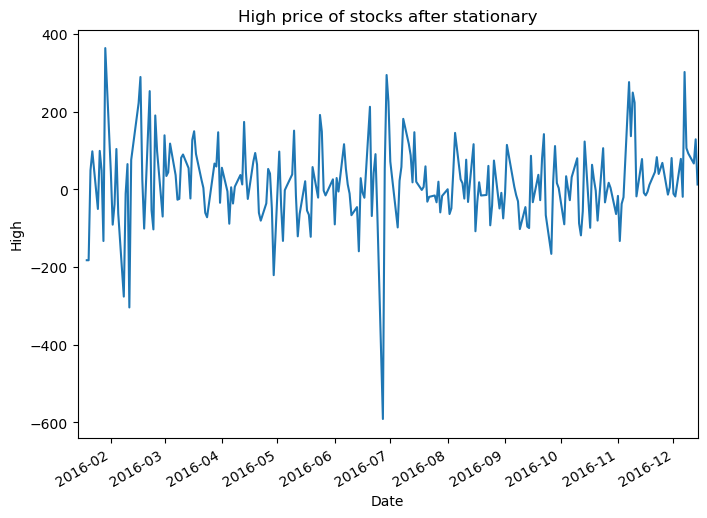

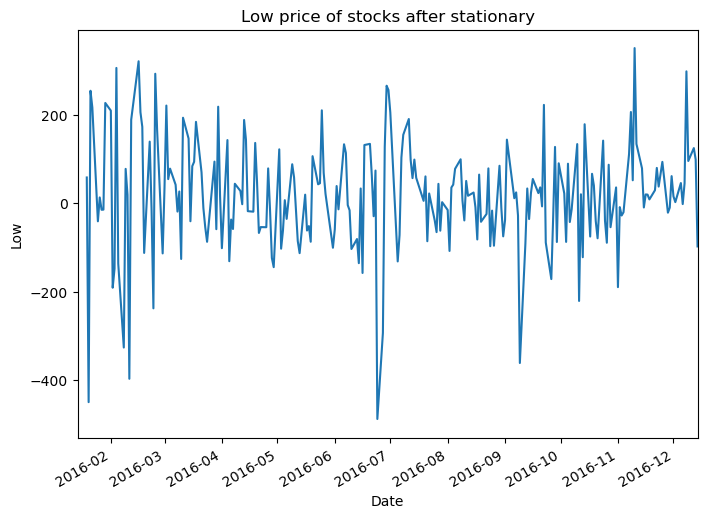

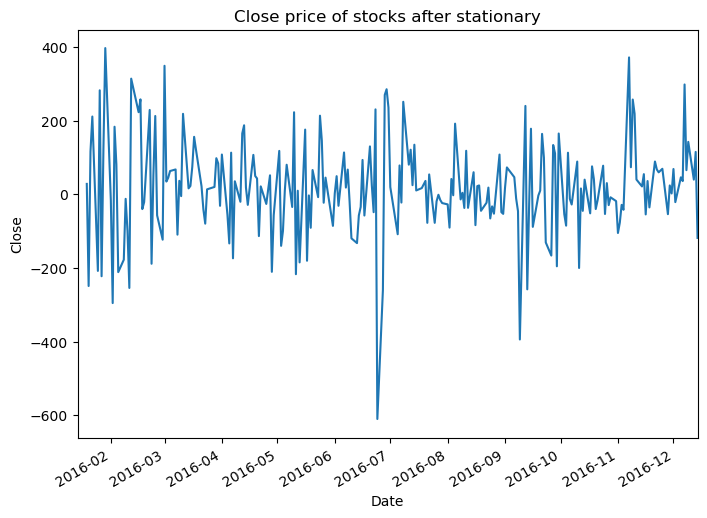

In [34]:
for c in train_diff[['Open', 'High', 'Low', 'Close']]:
    train_diff[str(c)].plot(figsize=(8, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} price of stocks after stationary")
    plt.xlim(pd.to_datetime('2016-01-14'), pd.to_datetime('2016-12-14'))
    plt.show()

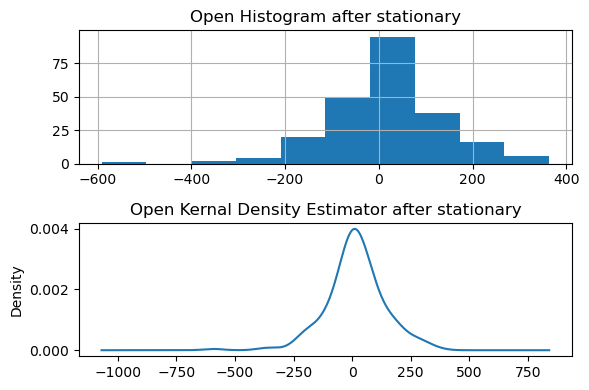

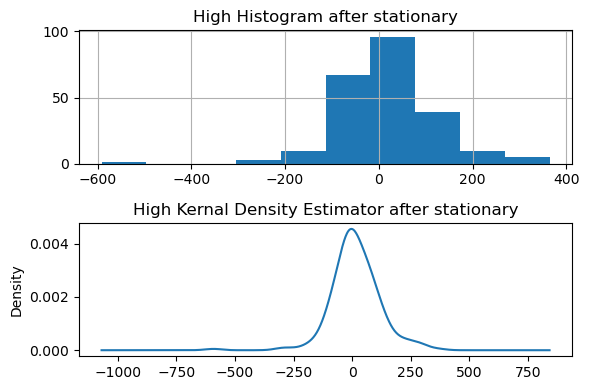

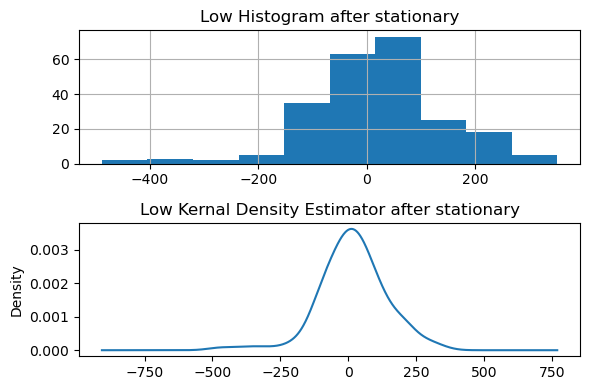

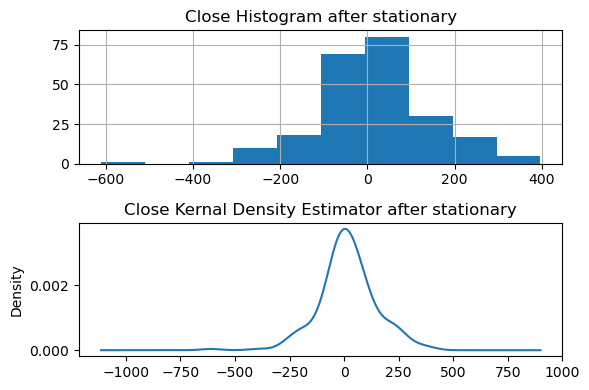

In [35]:
for c in train_diff[['Open', 'High', 'Low', 'Close']]:
    plt.figure(1, figsize=(6,4))
    plt.subplot(211)
    plt.title(f"{str(c)} Histogram after stationary")
    train_diff[str(c)].hist()
    plt.subplot(212)
    train_diff[str(c)].plot(kind='kde')
    plt.title(f"{str(c)} Kernal Density Estimator after stationary")
    plt.tight_layout() 
    plt.show()

In [36]:
train_diff.head(10)

,Open,High,Low,Close
Date,,,,
2016-01-19,-344.879883,-182.370117,58.139648,27.939453
2016-01-20,-20.000000,-182.509766,-449.690430,-249.279297
2016-01-21,-220.580078,49.139649,254.100586,115.939454
2016-01-22,152.229492,98.200195,216.439453,210.830078
2016-01-25,165.360352,-50.330078,-40.949218,-208.290039
2016-01-26,-193.299805,99.330078,13.009765,282.010742
2016-01-27,275.580078,49.240234,-14.860351,-222.770508
2016-01-28,-208.459961,-132.890625,-14.580078,125.179687
2016-01-29,129.979493,364.161133,226.540039,396.661133


### What is the Johansen Cointegration Test?
The Johansen Cointegration Test is a statistical test used to determine whether a group of non-stationary time series are cointegrated — i.e., if a long-run equilibrium relationship exists among them.

Cointegration means that even though individual time series are not stationary (they have trends), a linear combination of them is stationary — suggesting a stable, long-run relationship.

In [37]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):                     # Define a function to perform Johansen cointegration test
    res = coint_johansen(df, -1, 5)             # Apply Johansen test with lag -1 (automatic) and det_order = 5 (both trend and intercept)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}       # Map confidence levels to column indices in critical values table
    traces = res.lr1                            # Extract trace statistics from the test result
    cvts = res.cvt[:, d[str(1 - 0.05)]]         # Extract 95% critical values for comparison

    def adjust(val, length=6):                  # Helper function to format text output with padding
        return str(val).ljust(length)

    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)  # Header for results output

    for col, trace, cvt in zip(df.columns, traces, cvts):      # Iterate through each variable's test result
        print(adjust(col), '> ', adjust(round(trace, 2), 9),   # Print formatted test statistics
              ">", adjust(cvt, 8), ' =>  ', trace > cvt)       # Compare trace stat to critical value and show if significant


cointegration_test(train_diff[['Open', 'High', 'Low', 'Close']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   >  311.57    > 40.1749   =>   True
High   >  201.62    > 24.2761   =>   True
Low    >  102.52    > 12.3212   =>   True
Close  >  32.21     > 4.1296    =>   True


In [38]:
for i in [1,2,3,4,5,6,7,8,9]:   # Loop through lag orders from 1 to 9

    model = VAR(train_diff)     # Initialize a VAR model using differenced training data
    results = model.fit(i)      # Fit the model with lag order i

    print(f'Order : {i}, AIC:  {results.aic}, BIC: {results.bic}')  # Print AIC and BIC values for each lag

Order : 1, AIC:  32.33907657947465, BIC: 32.63803999764189
Order : 2, AIC:  31.801631080906866, BIC: 32.34143017316867
Order : 3, AIC:  31.548769661837937, BIC: 32.33090112107316
Order : 4, AIC:  31.529049396699733, BIC: 32.5550256133902
Order : 5, AIC:  31.536096482336305, BIC: 32.807445774101225
Order : 6, AIC:  31.572569230449268, BIC: 33.090836075873455
Order : 7, AIC:  31.5950147196233, BIC: 33.361759996476806
Order : 8, AIC:  31.63403809689653, BIC: 33.65083932484601
Order : 9, AIC:  31.6600787188423, BIC: 33.92853030675715


In [39]:
def inverse_diff(actual_df, pred_df):   # Define function to invert differencing
    
    df_res = pred_df.copy()         # Create a copy of the predicted differenced DataFrame
    columns = actual_df.columns     # Get column names from the original DataFrame

    for col in columns:                                          # Loop through each column
        df_res[str(col)+'_1st_inv_diff'] = (                     # Create a new column for the inverted values
            actual_df[col].iloc[-1] + df_res[str(col)].cumsum()  # Add the last actual value to the cumulative sum of differences
        )
    return df_res                   # Return the reconstructed DataFrame

In [40]:
results = model.fit(4)           # Fit the VAR model using lag order 4
display(results.summary())       # Display summary of the model results

z = results.forecast(                                                  # Generate forecasted values
    y=train_diff[['Open', 'High', 'Low', 'Close']].values, steps=30    # Use training differenced data and forecast next 30 steps
)
df_pred = pd.DataFrame(z, columns=['Open', 'High', 'Low', 'Close'])    # Convert forecasted values to DataFrame with column names

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 11, Apr, 2025
Time:                     15:19:56
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    32.5550
Nobs:                     227.000    HQIC:                   31.9430
Log likelihood:          -4798.94    FPE:                4.93606e+13
AIC:                      31.5290    Det(Omega_mle):     3.69764e+13
--------------------------------------------------------------------
Results for equation Open
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            3.203119         2.016085            1.589           0.112
L1.Open         -0.680835         0.102210           -6.661           0.000
L1.High         -0.089930         0.048603           -1.850           0.064
L1.Lo

In [41]:
# Arrange an index for aligning plots:
df_pred["new_index"] = range(233, 263)
df_pred = df_pred.set_index("new_index")
df_pred.head()

,Open,High,Low,Close
new_index,,,,
233,-88.065500,-95.117550,-62.425255,-10.727882
234,-5.772303,-11.205045,15.521340,-13.508886
235,-0.434844,38.496234,31.424223,64.707119
236,51.606931,41.327721,32.770536,14.358589
237,20.084552,15.328065,27.850804,20.123736


In [42]:
# Let’s inverse the differenced prediction
res = inverse_diff(df2[['Open', 'High', 'Low', 'Close' ]],df_pred)
res.head()

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
new_index,,,,,,,,
233,-88.065500,-95.117550,-62.425255,-10.727882,19940.553641,19933.501591,19807.965370,19960.402977
234,-5.772303,-11.205045,15.521340,-13.508886,19934.781338,19922.296546,19823.486710,19946.894090
235,-0.434844,38.496234,31.424223,64.707119,19934.346494,19960.792781,19854.910933,20011.601209
236,51.606931,41.327721,32.770536,14.358589,19985.953425,20002.120502,19887.681469,20025.959798
237,20.084552,15.328065,27.850804,20.123736,20006.037977,20017.448567,19915.532272,20046.083533


In [43]:
# Evaluate the results individually:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
 MSE is : 96475.65112756054
 MAE is : 272.41117065567283
RMSE is : 310.6052979708501
MAPE is : 1.369727903887651
  R2 is : -14.781846912253211

Evaluation metric for High
 MSE is : 76165.26004845892
 MAE is : 233.3943951082006
RMSE is : 275.9805428802163
MAPE is : 1.1709231240570384
  R2 is : -12.68519169812707

Evaluation metric for Low
 MSE is : 84415.19485871615
 MAE is : 239.85005825950623
RMSE is : 290.54293118008593
MAPE is : 1.2104917099059314
  R2 is : -8.885093043822414

Evaluation metric for Close
 MSE is : 120535.30355185564
 MAE is : 312.7798135745027
RMSE is : 347.18194588983977
MAPE is : 1.5729127244970404
  R2 is : -14.91072270418992



In [44]:
test.head()

,Open,High,Low,Close
Date,,,,
2016-12-15,19811.500000,19951.289063,19811.500000,19852.240234
2016-12-16,19909.009766,19923.169922,19821.000000,19843.410156
2016-12-19,19836.660156,19917.779297,19832.949219,19883.060547
2016-12-20,19920.589844,19987.630859,19920.419922,19974.619141
2016-12-21,19968.970703,19986.560547,19941.960938,19941.960938


In [45]:
test.tail()

,Open,High,Low,Close
Date,,,,
2017-01-24,19794.679688,19949.240234,19786.710938,19912.710938
2017-01-25,19994.480469,20082.000000,19994.480469,20068.509766
2017-01-26,20076.250000,20125.580078,20067.529297,20100.910156
2017-01-27,20103.359375,20115.970703,20072.640625,20093.779297
2017-01-30,20028.619141,20028.619141,19870.390625,19971.130859


In [46]:
train.head()

,Open,High,Low,Close
Date,,,,
2016-01-15,16354.330078,16354.330078,15842.110352,15988.080078
2016-01-19,16009.450195,16171.959961,15900.250000,16016.019531
2016-01-20,15989.450195,15989.450195,15450.559570,15766.740234
2016-01-21,15768.870117,16038.589844,15704.660156,15882.679688
2016-01-22,15921.099609,16136.790039,15921.099609,16093.509766


In [47]:
res.head()

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
new_index,,,,,,,,
233,-88.065500,-95.117550,-62.425255,-10.727882,19940.553641,19933.501591,19807.965370,19960.402977
234,-5.772303,-11.205045,15.521340,-13.508886,19934.781338,19922.296546,19823.486710,19946.894090
235,-0.434844,38.496234,31.424223,64.707119,19934.346494,19960.792781,19854.910933,20011.601209
236,51.606931,41.327721,32.770536,14.358589,19985.953425,20002.120502,19887.681469,20025.959798
237,20.084552,15.328065,27.850804,20.123736,20006.037977,20017.448567,19915.532272,20046.083533


In [48]:
res.index = test.index  # Now they share the same time index
res.head()

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
Date,,,,,,,,
2016-12-15,-88.065500,-95.117550,-62.425255,-10.727882,19940.553641,19933.501591,19807.965370,19960.402977
2016-12-16,-5.772303,-11.205045,15.521340,-13.508886,19934.781338,19922.296546,19823.486710,19946.894090
2016-12-19,-0.434844,38.496234,31.424223,64.707119,19934.346494,19960.792781,19854.910933,20011.601209
2016-12-20,51.606931,41.327721,32.770536,14.358589,19985.953425,20002.120502,19887.681469,20025.959798
2016-12-21,20.084552,15.328065,27.850804,20.123736,20006.037977,20017.448567,19915.532272,20046.083533


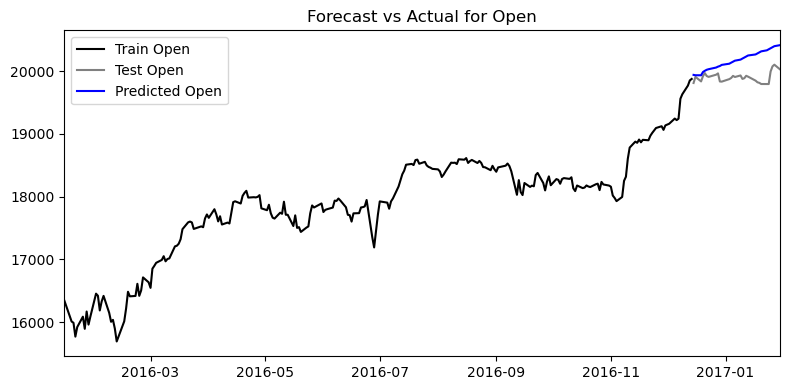

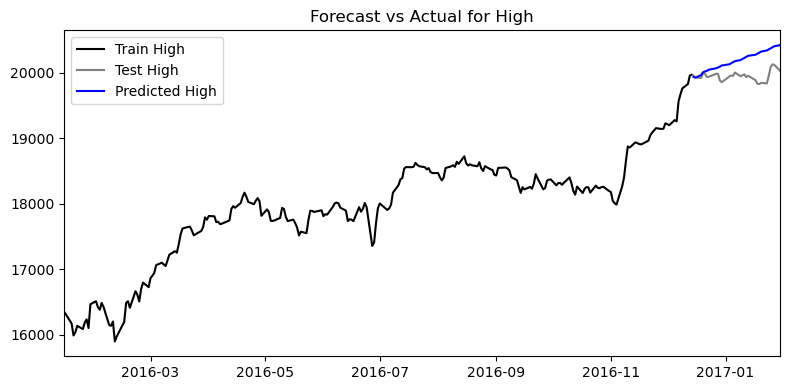

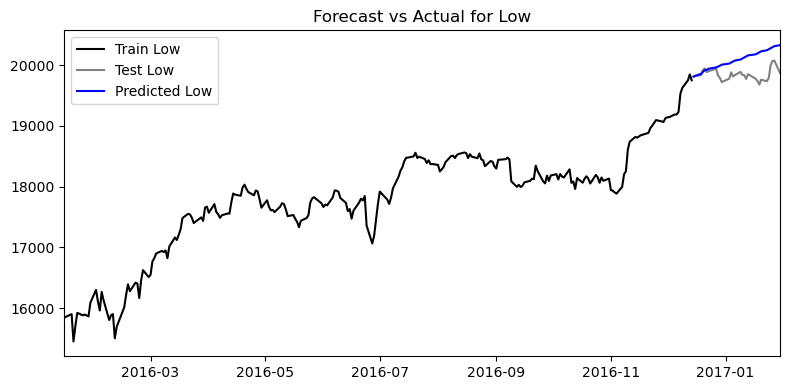

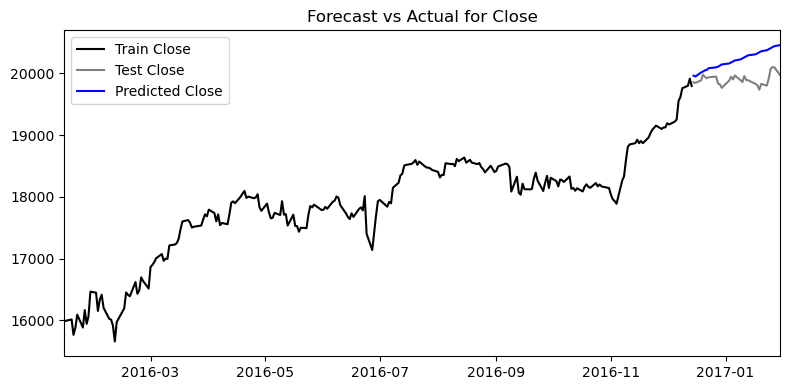

In [49]:
# Plot the results for each selected feature
for i in ['Open', 'High', 'Low', 'Close']:

    plt.rcParams["figure.figsize"] = [8, 4]      

    plt.plot(train[str(i)], label='Train ' + str(i), color='black')                
    plt.plot(test[str(i)], label='Test ' + str(i), color = 'gray')           
    plt.plot(res[str(i) + '_1st_inv_diff'], label=f'Predicted {i}', color = 'blue')

    plt.legend(loc=2)                                          
    plt.title(f'Forecast vs Actual for {i}')                        
    plt.xlim(pd.to_datetime('2016-01-15'), pd.to_datetime('2017-01-30'))  
    #plt.ylim(0, 30000)
    plt.tight_layout()                                              
    plt.show();                                                      

# VARMA with AutoARIMA

In [50]:
from pmdarima import auto_arima

pq = []

for name, column in train_diff[[ 'Open', 'High', 'Low', 'Close'  ]].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Open
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2891.139, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2887.158, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2889.136, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2889.135, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2885.680, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2887.514, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2887.501, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2889.092, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.283 seconds
optimal order for:Open is: (0, 0, 0) 


Searching order of p and q for : High
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2806.440, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2811.486, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2808.164, Time=0.02

In [51]:
pq

[(0, 0, 0), (0, 0, 2), (0, 0, 2), (0, 0, 1)]

In [52]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [53]:
from statsmodels.tsa.statespace.varmax import VARMAX


# Initialize results table
df_results_moni = pd.DataFrame(columns=['p', 'q', 'RMSE Open', 'RMSE High', 'RMSE Low', 'RMSE Close'])

print('Grid Search Started')
start = timer()

for i in pq:
    
    if i[0] == 0 and i[2] == 0:               # Skip case where p=0 and q=0
        continue
    
    print(f' Running for {i}')
    
    model = VARMAX(train_diff[['Open', 'High', 'Low', 'Close']], order=(i[0], i[2])).fit(disp=False)
    result = model.forecast(steps=30)
    
    inv_res = inverse_diff(df2[['Open', 'High', 'Low', 'Close']], result)
    
    Opensrmse = np.sqrt(metrics.mean_squared_error(test['Open'], inv_res['Open_1st_inv_diff']))
    Highrmse = np.sqrt(metrics.mean_squared_error(test['High'], inv_res['High_1st_inv_diff']))
    Lowrmse = np.sqrt(metrics.mean_squared_error(test['Low'], inv_res['Low_1st_inv_diff']))
    Closermse = np.sqrt(metrics.mean_squared_error(test['Close'], inv_res['Close_1st_inv_diff']))
    
    # Replace .append with pd.concat to follow pandas best practices
    new_row = pd.DataFrame([{
        'p': i[0],
        'q': i[2],
        'RMSE Open': Opensrmse,
        'RMSE High': Highrmse,
        'RMSE Low': Lowrmse,
        'RMSE Close': Closermse
    }])
    
    df_results_moni = pd.concat([df_results_moni, new_row], ignore_index=True)

end = timer()
print(f'Total time taken to complete grid search in seconds: {end - start:.2f}')

Grid Search Started
 Running for (0, 0, 2)
 Running for (0, 0, 2)
 Running for (0, 0, 1)
Total time taken to complete grid search in seconds: 7.70


In [54]:
df_results_moni.sort_values(by = ['RMSE Open','RMSE High','RMSE Low','RMSE Close'] )

,p,q,RMSE Open,RMSE High,RMSE Low,RMSE Close
0,0,2,263.130855,188.565294,285.854677,318.124744
1,0,2,263.130855,188.565294,285.854677,318.124744
2,0,1,313.952510,209.777234,336.609854,345.606855


In [55]:
# from above example we can see that p=0 and q=2 gives least RMSE
model = VARMAX(train_diff[[ 'Open', 'High', 'Low', 'Close' ]], order=(0,2)).fit( disp=False)
result = model.forecast(steps = 30)

In [56]:
res = inverse_diff(df2[['Open', 'High', 'Low', 'Close' ]],result)
res.head()

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
231,-96.998947,-127.211515,-18.430656,-5.353003,19931.620194,19901.407626,19851.959969,19965.777856
232,-14.435045,-37.042202,-3.056834,-7.231783,19917.185148,19864.365424,19848.903135,19958.546073
233,15.362115,15.537095,16.851591,16.495722,19932.547264,19879.902519,19865.754725,19975.041794
234,15.362115,15.537095,16.851591,16.495722,19947.909379,19895.439614,19882.606316,19991.537516
235,15.362115,15.537095,16.851591,16.495722,19963.271494,19910.976710,19899.457907,20008.033237


In [57]:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
 MSE is : 69237.84671487952
 MAE is : 224.08113419006233
RMSE is : 263.13085473748515
MAPE is : 1.1269611510337043
  R2 is : -10.326185256251943

Evaluation metric for High
 MSE is : 35556.870018752656
 MAE is : 151.35665139880948
RMSE is : 188.56529378110028
MAPE is : 0.7596159468466755
  R2 is : -5.388773334226445

Evaluation metric for Low
 MSE is : 81712.89622950285
 MAE is : 237.89357799952705
RMSE is : 285.85467676688944
MAPE is : 1.2006309036569693
  R2 is : -8.568651514229604

Evaluation metric for Close
 MSE is : 101203.35303840977
 MAE is : 281.76119700249706
RMSE is : 318.1247444610522
MAPE is : 1.417081868144975
  R2 is : -12.358895190699382



In [58]:
res.head()

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
231,-96.998947,-127.211515,-18.430656,-5.353003,19931.620194,19901.407626,19851.959969,19965.777856
232,-14.435045,-37.042202,-3.056834,-7.231783,19917.185148,19864.365424,19848.903135,19958.546073
233,15.362115,15.537095,16.851591,16.495722,19932.547264,19879.902519,19865.754725,19975.041794
234,15.362115,15.537095,16.851591,16.495722,19947.909379,19895.439614,19882.606316,19991.537516
235,15.362115,15.537095,16.851591,16.495722,19963.271494,19910.976710,19899.457907,20008.033237


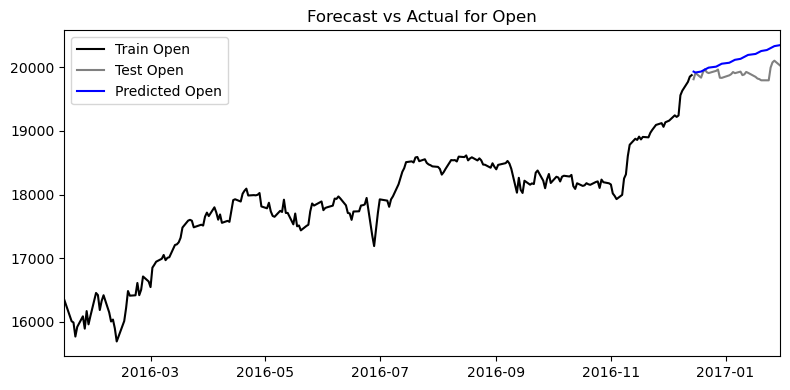

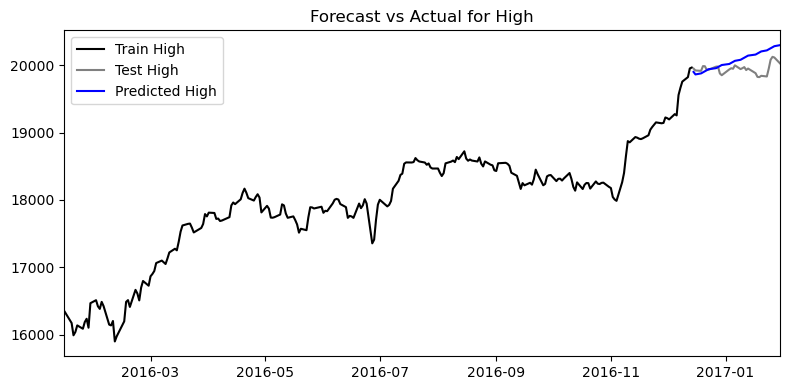

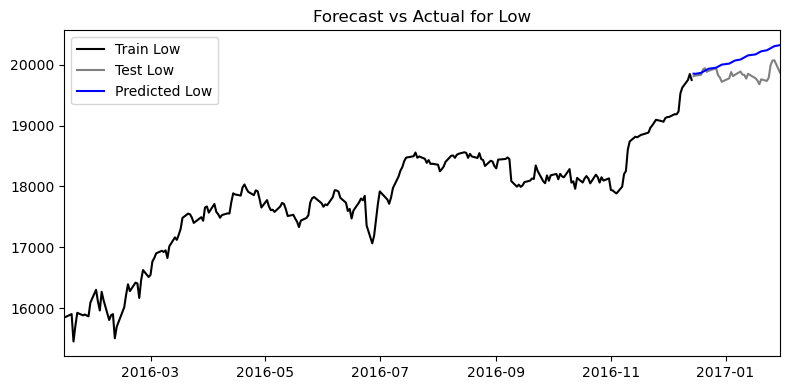

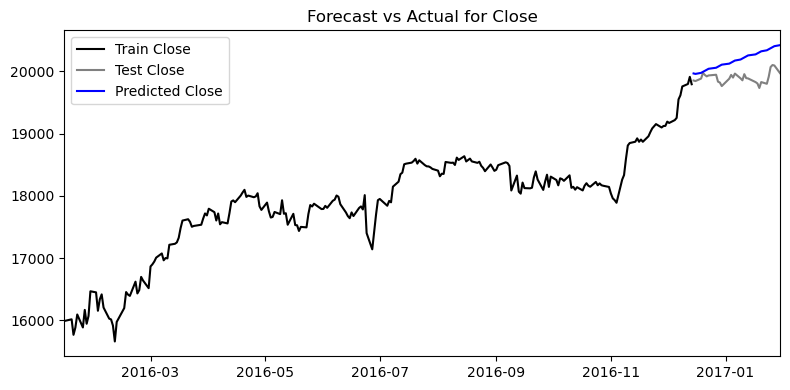

In [59]:
res.index = test.index  # Now they share the same time index

# Plot the results for each selected feature
for i in ['Open', 'High', 'Low', 'Close']:

    plt.rcParams["figure.figsize"] = [8, 4]      

    plt.plot(train[str(i)], label='Train ' + str(i), color='black')                
    plt.plot(test[str(i)], label='Test ' + str(i), color = 'gray')           
    plt.plot(res[str(i) + '_1st_inv_diff'], label=f'Predicted {i}', color = 'blue')

    plt.legend(loc=2)                                          
    plt.title(f'Forecast vs Actual for {i}')                        
    plt.xlim(pd.to_datetime('2016-01-15'), pd.to_datetime('2017-01-30'))  
    #plt.ylim(0, 30000)
    plt.tight_layout()                                              
    plt.show();      

#  VARMA with Gird Search

In [60]:
def inverse_diff(actual_df, pred_df):
    
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_res[str(col)+'_1st_inv_diff'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
        
    return df_res

In [61]:
from sklearn.model_selection import ParameterGrid


param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}

pg = list(ParameterGrid(param_grid))
pg

[{'p': 1, 'q': 1, 'tr': 'n'},
 {'p': 1, 'q': 1, 'tr': 'c'},
 {'p': 1, 'q': 1, 'tr': 't'},
 {'p': 1, 'q': 1, 'tr': 'ct'},
 {'p': 1, 'q': 2, 'tr': 'n'},
 {'p': 1, 'q': 2, 'tr': 'c'},
 {'p': 1, 'q': 2, 'tr': 't'},
 {'p': 1, 'q': 2, 'tr': 'ct'},
 {'p': 1, 'q': 3, 'tr': 'n'},
 {'p': 1, 'q': 3, 'tr': 'c'},
 {'p': 1, 'q': 3, 'tr': 't'},
 {'p': 1, 'q': 3, 'tr': 'ct'},
 {'p': 2, 'q': 1, 'tr': 'n'},
 {'p': 2, 'q': 1, 'tr': 'c'},
 {'p': 2, 'q': 1, 'tr': 't'},
 {'p': 2, 'q': 1, 'tr': 'ct'},
 {'p': 2, 'q': 2, 'tr': 'n'},
 {'p': 2, 'q': 2, 'tr': 'c'},
 {'p': 2, 'q': 2, 'tr': 't'},
 {'p': 2, 'q': 2, 'tr': 'ct'},
 {'p': 2, 'q': 3, 'tr': 'n'},
 {'p': 2, 'q': 3, 'tr': 'c'},
 {'p': 2, 'q': 3, 'tr': 't'},
 {'p': 2, 'q': 3, 'tr': 'ct'},
 {'p': 3, 'q': 1, 'tr': 'n'},
 {'p': 3, 'q': 1, 'tr': 'c'},
 {'p': 3, 'q': 1, 'tr': 't'},
 {'p': 3, 'q': 1, 'tr': 'ct'},
 {'p': 3, 'q': 2, 'tr': 'n'},
 {'p': 3, 'q': 2, 'tr': 'c'},
 {'p': 3, 'q': 2, 'tr': 't'},
 {'p': 3, 'q': 2, 'tr': 'ct'},
 {'p': 3, 'q': 3, 'tr': 'n'},
 {

In [62]:
# Initialize the result DataFrame
df_results_moni = pd.DataFrame(columns=['p', 'q', 'tr', 'RMSE open', 'RMSE high', 'RMSE low', 'RMSE close'])

print('Starting grid search')
start = timer()

# Loop through parameter grid
for a, b in enumerate(pg):
    p = b.get('p')                           # Order p
    q = b.get('q')                           # Order q
    tr = b.get('tr')                         # Trend component

    model = VARMAX(train_diff, order=(p, q), trend=tr).fit(disp=False)    # Fit VARMAX model
    z = model.forecast(
        y=train_diff[['Open', 'High', 'Low', 'Close']].values,            # Past values
        steps=30                                                          # Forecast horizon
    )

    df_pred = pd.DataFrame(z, columns=['Open', 'High', 'Low', 'Close'])  # Forecasted values
    res = inverse_diff(df2[['Open', 'High', 'Low', 'Close']], df_pred)    # Reverse differencing

    # Compute RMSE for each variable
    openrmse = np.sqrt(metrics.mean_squared_error(test.Open, res.Open_1st_inv_diff))
    highrmse = np.sqrt(metrics.mean_squared_error(test.High, res.High_1st_inv_diff))
    lowrmse = np.sqrt(metrics.mean_squared_error(test.Low, res.Low_1st_inv_diff))
    closermse = np.sqrt(metrics.mean_squared_error(test.Close, res.Close_1st_inv_diff))

    # Create new row and concat to result DataFrame
    new_row = pd.DataFrame([{
        'p': p,
        'q': q,
        'tr': tr,
        'RMSE open': openrmse,
        'RMSE high': highrmse,
        'RMSE low': lowrmse,
        'RMSE close': closermse
    }])
    df_results_moni = pd.concat([df_results_moni, new_row], ignore_index=True)

end = timer()
print(f'Total time taken to complete grid search in seconds: {end - start:.2f}')

Starting grid search
Total time taken to complete grid search in seconds: 255.75


In [63]:
df_results_moni.head(5)

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
0,1,1,n,100.279959,84.298291,102.887818,125.301769
1,1,1,c,330.865584,241.607115,340.065040,367.457097
2,1,1,t,499.325336,443.789763,492.429474,542.849271
3,1,1,ct,381.551902,330.005293,250.595542,387.591876
4,1,2,n,81.056732,96.075211,94.019972,95.474344


In [64]:
df_results_moni.sort_values(by = ['RMSE open','RMSE high','RMSE low','RMSE close'] )

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
4,1,2,n,81.056732,96.075211,94.019972,95.474344
32,3,3,n,82.547006,80.967658,96.323598,103.682861
28,3,2,n,83.304469,78.547097,96.366694,102.215335
24,3,1,n,86.695660,75.559058,98.440191,107.321370
0,1,1,n,100.279959,84.298291,102.887818,125.301769
12,2,1,n,103.033784,75.010513,93.117632,130.966674
8,1,3,n,116.282923,79.117689,119.422008,136.865792
16,2,2,n,122.991009,78.943563,99.075711,153.426016
20,2,3,n,156.395407,80.581533,157.900698,180.551834
35,3,3,ct,217.747768,183.457689,131.674270,197.541481


In [65]:
df_results_moni.sort_values(by = ['RMSE open','RMSE high','RMSE low','RMSE close'] )

,p,q,tr,RMSE open,RMSE high,RMSE low,RMSE close
4,1,2,n,81.056732,96.075211,94.019972,95.474344
32,3,3,n,82.547006,80.967658,96.323598,103.682861
28,3,2,n,83.304469,78.547097,96.366694,102.215335
24,3,1,n,86.695660,75.559058,98.440191,107.321370
0,1,1,n,100.279959,84.298291,102.887818,125.301769
12,2,1,n,103.033784,75.010513,93.117632,130.966674
8,1,3,n,116.282923,79.117689,119.422008,136.865792
16,2,2,n,122.991009,78.943563,99.075711,153.426016
20,2,3,n,156.395407,80.581533,157.900698,180.551834
35,3,3,ct,217.747768,183.457689,131.674270,197.541481


In [66]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model = VARMAX(train_diff[[ 'Open', 'High', 'Low', 'Close' ]], order=(1,2),trends = 'n').fit( disp=False)
result = model.forecast(steps = 30)

In [67]:
res = inverse_diff(df2[['Open', 'High', 'Low', 'Close' ]],result)
res.head()

,Open,High,Low,Close,Open_1st_inv_diff,High_1st_inv_diff,Low_1st_inv_diff,Close_1st_inv_diff
231,-96.193333,-110.055515,-29.499245,18.889888,19932.425808,19918.563626,19840.891380,19990.020747
232,31.582992,6.341893,23.338235,-13.070311,19964.008800,19924.905519,19864.229615,19976.950436
233,-12.162170,3.217451,-5.861942,16.394479,19951.846630,19928.122970,19858.367672,19993.344914
234,17.382422,17.975840,23.801025,17.822301,19969.229052,19946.098810,19882.168697,20011.167215
235,17.237686,14.543337,13.342375,14.378944,19986.466738,19960.642146,19895.511073,20025.546159


In [68]:
for i in ['Open', 'High', 'Low', 'Close' ]:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(test[str(i)] , res[str(i)+'_1st_inv_diff'])

Evaluation metric for Open
 MSE is : 78995.16809230439
 MAE is : 245.1749328128472
RMSE is : 281.0607907416194
MAPE is : 1.2329413463291552
  R2 is : -11.922324286695703

Evaluation metric for High
 MSE is : 46967.631132277274
 MAE is : 176.22094063037875
RMSE is : 216.72016780234662
MAPE is : 0.8843242986436927
  R2 is : -7.439031590559647

Evaluation metric for Low
 MSE is : 73102.40748290501
 MAE is : 224.28771854107703
RMSE is : 270.3745688538495
MAPE is : 1.132072463537553
  R2 is : -7.560355761843301

Evaluation metric for Close
 MSE is : 101557.95045954945
 MAE is : 286.6181595033687
RMSE is : 318.6815816132923
MAPE is : 1.4415411223086227
  R2 is : -12.40570223455394



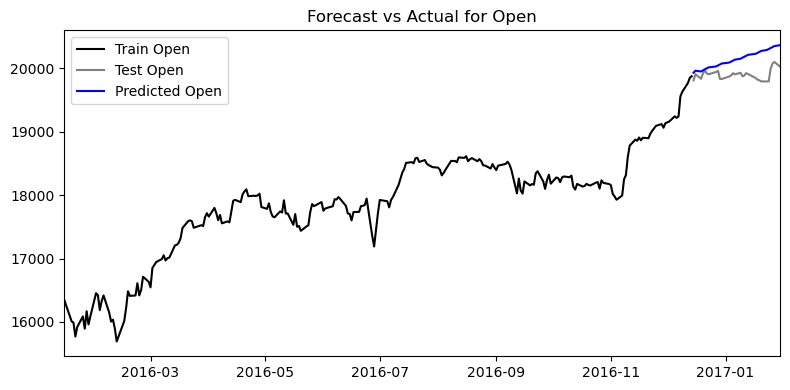

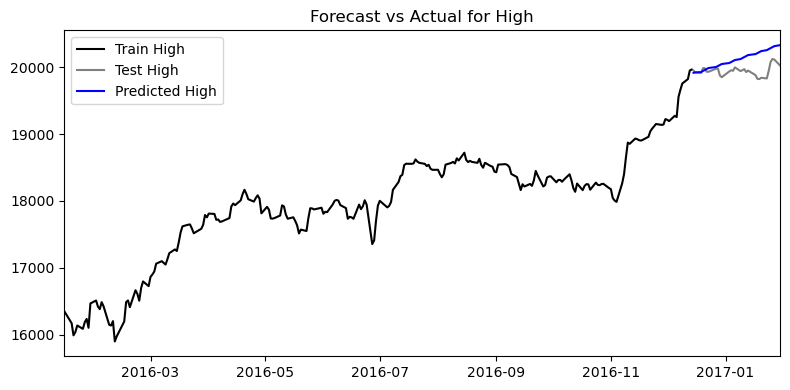

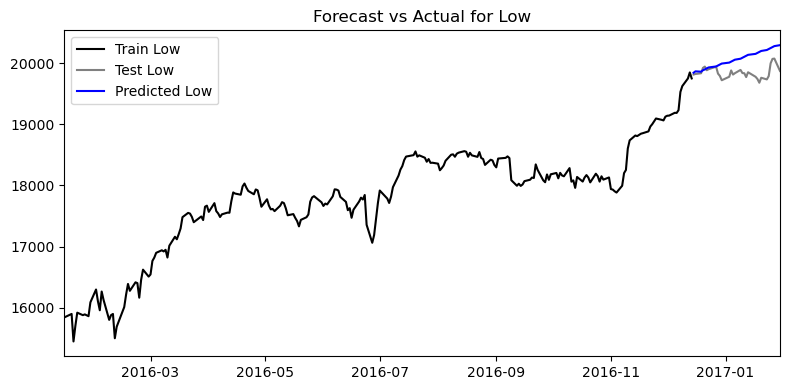

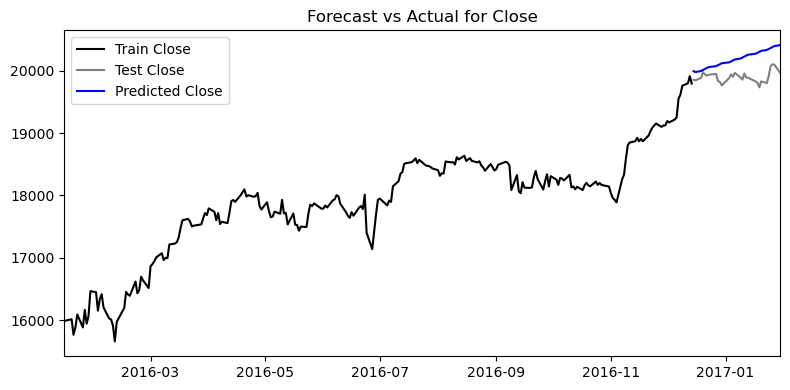

In [69]:
res.index = test.index  # Now they share the same time index

# Plot the results for each selected feature
for i in ['Open', 'High', 'Low', 'Close']:

    plt.rcParams["figure.figsize"] = [8, 4]      

    plt.plot(train[str(i)], label='Train ' + str(i), color='black')                
    plt.plot(test[str(i)], label='Test ' + str(i), color = 'gray')           
    plt.plot(res[str(i) + '_1st_inv_diff'], label=f'Predicted {i}', color = 'blue')

    plt.legend(loc=2)                                          
    plt.title(f'Forecast vs Actual for {i}')                        
    plt.xlim(pd.to_datetime('2016-01-15'), pd.to_datetime('2017-01-30'))  
    plt.tight_layout()                                              
    plt.show();      